<a href="https://colab.research.google.com/github/Anoshawott/NLP-Model-Review/blob/main/nlp_model_review_evaluating_text_classification_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Model Review: Evaluating Text Classification Techniques – RNNs Triumph Over Transformers

### Executive Summary

In the era of **Generative AI and transformative advancements in NLP**, transformer models have emerged as comprehensive reasoners of unstructured textual data, praised for their ability to capture **complex syntactic structures and contextual nuances**. With the remarkable success of models like Gemini, GPT-4.1, and their successors, it is natural to assume that transformers would be the optimal choice for classifying short-form questions from an online forum.

However, contrary to initial expectations, this comprehensive model review reveals that **traditional methods, specifically RNN-based approaches, outperformed transformer models** in both accuracy and computational efficiency. Despite the inherent strengths of transformers, their **high processing demands and marginal performance gains** rendered them less suitable for this particular classification task. Instead, simpler RNN models like GRU and LSTM demonstrated **30-40% higher classification performance**, highlighting that sometimes **traditional methods can outperform cutting-edge techniques when matched appropriately to the problem's characteristics**.

---

#### Key Insights and Observations

1. **Data Characteristics and Preprocessing:**
   - The dataset exhibited **category imbalances**, prompting the use of **stratified sampling** for train-test splits to enhance model generalisation.
   - **Noise analysis** revealed that equations and technical terminology were often misclassified as irrelevant or noisy. Careful consideration was given to retain these elements since they were contextually significant.
   - Vocabulary analysis identified that **n-grams and word frequency alone were insufficient** for robust classification, emphasising the need for context-aware models.

2. **Model Selection and Evaluation:**
   - Despite the **promising potential of transformer models**, their **high computational cost and marginal improvement** over traditional techniques made them less suitable for short-form question classification. Transformer metrics showed limited enhancement even after fine-tuning, including:
     - **F1-Score:** 0.591 (initial), 0.540 (post-category changes)
     - **Precision:** 0.803 (initial), 0.800 (post-category changes)
     - **Recall:** 0.559 (initial), 0.516 (post-category changes)
     - **Accuracy:** 0.559 (initial), 0.516 (post-category changes)
   - On the other hand, **RNN-based models (GRU and LSTM)** delivered significantly higher and more consistent performance with:
     - **Accuracy:** 89.50%
     - **Average Precision:** 88.73%
     - **Average Recall:** 87.65%
     - **Average F1-Score:** 88.15%
   - These results indicate that **RNNs, particularly GRU models, outperform transformers** for short-form text classification, offering a balanced trade-off between performance and computational efficiency.

3. **Recommendations and Next Steps:**
   - Further tuning and optimisation of RNN models could be explored, including **regularisation techniques and hyperparameter adjustments** to maximise model performance.
   - Investigating **additional data sources** with richer contextual information may enhance feature representation and model accuracy. However, it is crucial to balance model complexity with data availability and processing constraints.
   - Emphasis on **efficient model evaluation strategies** should continue, as data complexity and diversity remain key challenges in classification accuracy.

---

#### Conclusion
This study demonstrates that, while **transformer models carry immense potential and hype due to their success in Generative AI applications**, they are not universally superior. For this specific problem of **short-form question classification**, **traditional RNN-based models proved to be more effective**. These findings challenge the assumption that the most advanced models are always the best fit and highlight the importance of **carefully matching model architecture to the problem context**. The practical implications include **enhanced classification performance and efficient deployment** for real-world applications.

# Technical Details and Code Execution

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

pd.set_option('display.max_rows', 500)
tqdm.pandas()

# Load English tokenizer, POS tagger, parser, NER, and word vectors
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Specify the file path
file_path = 'data/questions.csv'

# Read the CSV file into a DataFrame
quest_df = pd.read_csv(file_path, header=None)
quest_df.columns = ['category', 'question', 'attribution']

# Initial Data Analysis

Quick inspection of the category counts. There is some degree of imbalances across the groups which may require some attention. For example we may want to consider stratified sets when preparing data during evaluation.

In [ ]:
quest_df.index.name = 'main_idx'
quest_df = quest_df.sort_values(by=['category', 'main_idx'])
quest_df.category.value_counts()

astronomy           9995
ai                  8287
opendata            5566
sports              5171
quantumcomputing    4681
computergraphics    3036
martialarts         1863
coffee              1254
beer                1065
Name: category, dtype: int64

We need to account for the possibility of duplicate questions. This could be possibly due to certain questions being asked more than once. For potential over fitting reasons we will try to address these by removing duplicates. It's also possible that there might be similar questions that could be considered "duplicates" however these are exceptions since we can consder these as a new type of question given its different use of wording - where classification ability should be based on how it is able to predict effectively on unseen examples. Therefore, overfitting is more of an issue for exact duplicates since we want to avoid the possibility of memorisation during evaluation, where we may artificially inflate the model performance.

In [ ]:
duplicates_count = quest_df.groupby('question',as_index=False).size()['size'].value_counts()
duplicates_count

1    40896
2       11
Name: size, dtype: int64

In [ ]:
quest_df = quest_df.drop_duplicates(subset=['question'])
quest_df.shape

(40907, 3)

In [ ]:
quest_df.head(10)

category                                           question  \
main_idx                                                               
8              ai  Are there any learning algorithms as powerful ...   
9              ai            Can DQN perform better than Double DQN?   
12             ai  How should I weight the factors that affect th...   
23             ai  Should I use exploration strategy in Policy Gr...   
24             ai         Why are autonomous cars categorized as AI?   
26             ai  How can I process neural network with 25000 in...   
27             ai  How do I know if my dataset is ready for a mac...   
33             ai  Can number of Leads be predicted based on prev...   
34             ai  What is the best algorithm for optimizing prof...   
45             ai       How should I interpret this validation plot?   

           attribution  
main_idx                
8         CC BY-SA 3.0  
9         CC BY-SA 4.0  
12        CC BY-SA 4.0  
23        CC BY-SA 4.0  
24        CC BY-SA 4.0  
26        CC BY-SA 4.0  
27        CC BY-SA 4.0  
33        CC BY-SA 3.0  
34        CC BY-SA 4.0  
45        CC BY-SA 4.0

Another key consideration is to check for missing values to assess the completeness of the data.

In [ ]:
# Print the count of missing values for the 'category' column
missing_category = quest_df['category'].isnull().sum()
print(f"Missing values in 'category' column: {missing_category}")

# Print the count of missing values for the 'question' column
missing_question = quest_df['question'].isnull().sum()
print(f"Missing values in 'question' column: {missing_question}")

Missing values in 'category' column: 0
Missing values in 'question' column: 0


For correctness sake let's remap the values of the category labels to their correct wordings.

In [ ]:
classes = quest_df['category'].unique().tolist()
classes

['quantumcomputing',
 'astronomy',
 'martialarts',
 'opendata',
 'sports',
 'ai',
 'computergraphics',
 'coffee',
 'beer']

In [ ]:
remap_dict = {'ai':'artificial intelligence',
              'astronomy':'astronomy',
              'beer':'beer',
              'coffee':'coffee',
              'computergraphics':'computer graphics',
              'martialarts':'martial arts',
              'opendata':'open data',
              'quantumcomputing':'quantum computing',
              'sports':'sports'}
quest_df['category'] = quest_df['category'].map(remap_dict)
quest_df

category                                           question  \
0      quantum computing  What is the difference between a qudit system ...   
1              astronomy   What does the Sun look like from the heliopause?   
2           martial arts  How to cope with rival that carries stone or f...   
3              open data  Is there an emotion speech detection - accurat...   
4              astronomy  Is it possible to steer the sight of a Liquid ...   
...                  ...                                                ...   
40913  computer graphics              culling meshes across mulitple layers   
40914          astronomy    Mapping selenographic coordinates onto a sphere   
40915  quantum computing  Prove that the partial trace is a quantum oper...   
40916       martial arts  How did Kayla Harrison supplement her Judo for...   
40917          open data      Need a dataset for automobile insurance fraud   

        attribution  
0      CC BY-SA 4.0  
1      CC BY-SA 4.0  
2      CC BY-SA 3.0  
3      CC BY-SA 3.0  
4      CC BY-SA 3.0  
...             ...  
40913  CC BY-SA 3.0  
40914  CC BY-SA 4.0  
40915  CC BY-SA 4.0  
40916  CC BY-SA 4.0  
40917  CC BY-SA 4.0  

[40907 rows x 3 columns]

Finally, lets assess the general length of texts to get an understanding if we are dealing with long or short forms of text. Given these are questions on an online forum its unlikely that these are too long, however let's confirm this assumption.

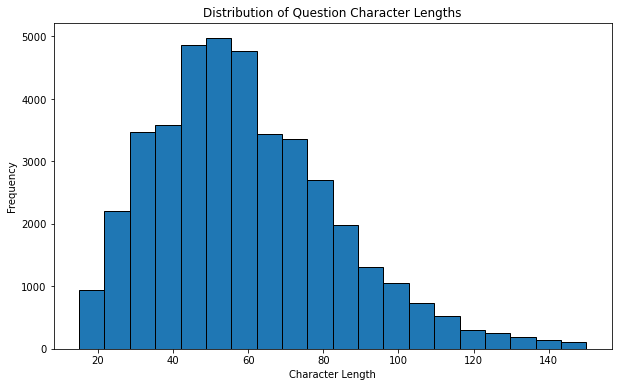

In [ ]:
# Calculate the length of each question
quest_df['question_length'] = quest_df['question'].apply(len)

# Plot the distribution of question lengths
plt.figure(figsize=(10, 6))
plt.hist(quest_df['question_length'], bins=20, edgecolor='black')
plt.title('Distribution of Question Character Lengths')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
quest_df['question_length'].value_counts()

50     756
47     734
44     727
49     727
45     720
52     717
57     708
60     708
51     704
55     702
53     697
43     697
61     686
56     683
59     681
48     680
46     673
54     670
58     659
41     643
62     638
42     633
63     631
65     615
39     615
40     605
38     598
64     596
37     593
35     579
33     539
34     537
67     536
68     535
36     530
69     525
66     522
70     514
31     513
73     485
71     481
32     480
72     478
76     456
74     443
30     436
75     426
77     405
29     388
28     386
78     385
27     382
80     376
79     375
82     368
81     343
25     339
83     337
84     317
24     314
26     308
85     303
87     274
23     265
88     258
91     254
89     253
86     240
90     221
92     218
93     218
22     217
21     210
94     208
95     194
97     175
20     174
96     169
99     167
98     165
19     156
103    133
101    132
18     130
100    122
102    121
104    120
106    110
105    107
17     106
107    103

On average, the questions are around 50 characters long which include questions like the below. As expected these are short-form texts.

In [ ]:
# Filter questions with length exactly 50 characters and get the first 10
filtered_questions = quest_df[quest_df['question_length'] == 50]['question'].values[:10]

# Print each question line by line
for question in filtered_questions:
    print(question)

How to avoid falling into the "local minima" trap?
Why do momentum techniques not work well for RNNs?
Are there companies that still use expert systems?
What's the commercial usage of "image captioning"?
Why would an AI need to 'wipe out the human race'?
What does "immediate vector-valued feedback" mean?
Why is DDPG not learning and it does not converge?
Extending a neural network to classify new objects
Best way to predict future frame of movie or game?
How to implement or avoid masking for transformer?


Inspecting the longest forms of questions these get as large as 150 characters, below are some examples. Similarly, these appear more as short-form texts than long-form despite these being the longest questions.

In [ ]:
# Filter questions with length exactly 50 characters and get the first 10
filtered_questions = quest_df[quest_df['question_length'] == 150]['question'].values[:10]

# Print each question line by line
for question in filtered_questions:
    print(question + '\n')

What are the ways to calculate the error rate of a deep Convolutional Neural Network, when the network produces different results using the same data?

How can I perform the forward pass in a neural network evolved with NEAT, given that some connections may not exist or there may be loopy connections?

‪Can a multi-camera system be used for localization, mapping, and obstacle detection in self-driving cars to within 10 cm of accuracy? Whither lidar?‬

How can I prevent the CNN from classifying a new input into one of the existing labels (it was trained with) when the input has a new different label?

Solving the supervised learning problem of learning $p(y \vert \mathbf{x})$ by using traditional unsupervised technologies to learn $p(\mathbf{x}, y)$

Why would the merger of spinning black holes within the accretion disk of a supermassive black hole cause them to "shoot straight up" out of the disk?

In the 1950's how were radio-astrometric positions with portable dishes so precise they 

# Exploratory Data Analysis

Before we delve into modelling it's important that we conduct the relevant Exploratory Data Analysis (EDA). This allows us to systematically examine the data, uncover any underlying patterns, trends, and potential anomalies that could affect predictive performance.

This prepartory step is key as it helps us ensure that the data is clean, well-understood, and properly formatted.

## Text Quality
Ensuring that we address noise and potential variability of questions due to typos and special characters are important to ensure best generalisation performance.

**Noise and Irrelevant Content**
- Detect and quantify the presence of noise, such as typos, special characters, or irrelevant information.

In the following we consider noise characters that are not letters (a-z, A-Z), digits (0-9) or whitespace characters (spaces, tabs, etc.). We then plot the distribution of questions that had a particular number of noise characters.

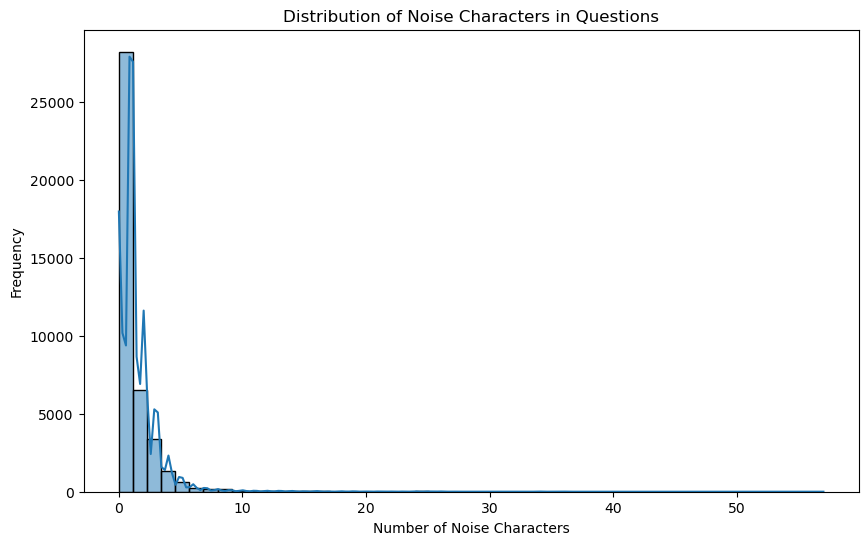

In [ ]:
# Function to detect noise
def detect_noise(text):
    noise_chars = re.findall(r'[^a-zA-Z0-9\s]', text)
    return len(noise_chars)

# Apply the function to the dataset
quest_df['noise_count'] = quest_df['question'].apply(detect_noise)

# Plot the noise distribution
plt.figure(figsize=(10, 6))
sns.histplot(quest_df['noise_count'], bins=50, kde=True)
plt.title('Distribution of Noise Characters in Questions')
plt.xlabel('Number of Noise Characters')
plt.ylabel('Frequency')
plt.show()

In [ ]:
num_noise = quest_df.noise_count.value_counts()
num_noise

1     18147
0     10048
2      6493
3      3384
4      1297
5       598
6       269
7       152
8        94
9        66
10       51
11       37
13       33
12       33
14       27
16       22
15       15
19       14
18       14
24       11
17        9
26        9
25        9
21        8
20        7
22        6
34        6
23        6
30        5
29        5
31        4
36        4
27        4
43        3
32        3
44        2
38        2
33        2
35        2
28        2
39        1
46        1
37        1
57        1
Name: noise_count, dtype: int64

These results imply that a question could have as many as 57 noise characters. It might be worth investigating what these high noise questions are and if they need to be addressed.

In [ ]:
top_noise_char = num_noise.tail(35).index.to_list()
top_noise_char

[9,
 10,
 11,
 13,
 12,
 14,
 16,
 15,
 19,
 18,
 24,
 17,
 26,
 25,
 21,
 20,
 22,
 34,
 23,
 30,
 29,
 31,
 36,
 27,
 43,
 32,
 44,
 38,
 33,
 35,
 28,
 39,
 46,
 37,
 57]

In [ ]:
top_noise_questions = quest_df[quest_df['noise_count'].isin(top_noise_char)]
top_noise_questions

category                                           question  \
main_idx                                                                        
107                     ai  Why is the space-complexity of greedy best-fir...   
904                     ai  How are the reward functions $R(s)$, $R(s, a)$...   
1456                    ai  What is meant by "known" in "A knowledge-base ...   
1955                    ai  keras ValueError: Error when checking model ta...   
2944                    ai  In the MINE paper, why is $\hat{G}_B$ biased, ...   
3052                    ai  Given statements $A$ and $B$, are the formulae...   
3429                    ai  What does the notation $\nabla_\theta \mathcal...   
3782                    ai  Which function $(\hat{y} - y)^2$ or $(y - \hat...   
3861                    ai  In YOLO, when is $\mathbb{1}_{i j}^{\mathrm{ob...   
4345                    ai  Why is "-0.5 * torch.sum(1 + sigma - mu.pow(2)...   
4665                    ai  Given an input $x \in R^{1\times d}$ and a net...   
4666                    ai  If the training data are linearly separable, w...   
4992                    ai  Why is $G_{t+1}$ is replaced with $v_*(S_{t+1}...   
5914                    ai  How do I convert an MDP with the reward functi...   
6366                    ai  What does $r : \mathcal{S} \times \mathcal{A} ...   
6638                    ai  $\frac{P(x_1 \mid y, s = 1) \dots P(x_n \mid y...   
7096                    ai  If the goal of training of a GAN is to have $P...   
7218                    ai  What are the meanings of these (P(x;y), P(x;y,...   
7387                    ai  Why is the margin attained with $\Phi=\left[2 ...   
8055                    ai  Meaning of the statement $\forall x \exists y ...   
8081                    ai  What does the notation $p_t = \text{max}_{i<t}...   
8338                    ai  In RL as probabilistic inference, why do we ta...   
8742                    ai  Best strategy for Classification of Science Su...   
9278                    ai  Why is the $\epsilon$ hyper-parameter (in the ...   
10782                   ai  Can an ML model sort a random sequence of numb...   
10845                   ai  How do I calculate $max_{a′}Q(s′,a′,w−)$ when ...   
11218                   ai  Why is the hypothesis function $h_{\theta}(x)$...   
11892                   ai  What is the difference between "out-of-distrib...   
12140                   ai  In the multi-head attention mechanism of the t...   
12587                   ai  During Backpropagation in LSTM, why is the pre...   
13684                   ai  Connection between the Bellman equation for th...   
13773                   ai  Does the paper "On the difficulty of training ...   
14672                   ai  Why doesn't the set $\{ -2, +2 \}$ in $E(X) = ...   
15088                   ai  What does the parameter $y$ stand for in funct...   
15351                   ai  Given two neural networks that compute two fun...   
15850                   ai  In Batch Normalisation, are $\hat{\mu}$, $\hat...   
15868                   ai  Why is the target $r + \gamma \max_{a'} Q(s', ...   
17120                   ai  Shouldn't the utility function of two-player z...   
17729                   ai  Is there a natural way to define the terminal ...   
18054                   ai  How can I go from $R(s)$ to $R(s,a)$ in this s...   
18206                   ai  Equivalence of the $Q(s,a)$ and $V(s)$ under o...   
18858                   ai  Why can we use a network to estimate $Q_\pi(s,...   
19179                   ai  In imitation learning, do you simply inject op...   
19552                   ai  What is the difference between the notations $...   
19826                   ai  How do we express $q_\pi(s,a)$ as a function o...   
20295                   ai  Prove that in such cases, it is possible to ﬁn...   
20826                   ai  How to prove $\mathcal H$ with VC dimension $d...   
21035                   ai  Why does this formula

It's more evident that these "high noise" characters are related to questions that present formulas and equations as part of their question. Depending on the models we use in classification this would be an important consideration, for example are they robust to interpretting equations.

Quick inspection of rows with a moderate number of noise characters (10-20) are mostly questions that make use of punctuation. Assuming that there are enough words to shape the context of the question then this should not be too much of an issue. It should be safe to assume that smaller counts of noise characters are also those using punctuation.

There is also the possible concern of overlap across categories if there is not enough context provided for questions with equations. To investigate if there is enough context after removing noise characters we should look at the dataframe of the high noise questions when these are removed. The below attempts to present this insight.

In [ ]:
# Function to remove noise characters
def remove_noise(text):
    # Remove non-alphanumeric and non-space characters
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Create a new DataFrame with noise removed
cleaned_df = top_noise_questions.copy()  # Create a copy to preserve the original filtered DataFrame
cleaned_df['question'] = cleaned_df['question'].apply(remove_noise)

In [ ]:
cleaned_df

category                                           question  \
main_idx                                                                        
107                     ai  Why is the spacecomplexity of greedy bestfirst...   
904                     ai  How are the reward functions Rs Rs a and Rs a ...   
1456                    ai  What is meant by known in A knowledgebase exhi...   
1955                    ai  keras ValueError Error when checking model tar...   
2944                    ai  In the MINE paper why is hatGB biased and how ...   
3052                    ai  Given statements A and B are the formulae lnot...   
3429                    ai    What does the notation nablatheta mathcalL mean   
3782                    ai  Which function haty  y2 or y  haty2 should I u...   
3861                    ai  In YOLO when is mathbb1i jmathrmobj  1 and wha...   
4345                    ai  Why is 05  torchsum1  sigma  mupow2  sigmaexp ...   
4665                    ai  Given an input x in R1times d and a network wi...   
4666                    ai  If the training data are linearly separable wh...   
4992                    ai  Why is Gt1 is replaced with vSt1 in the Bellma...   
5914                    ai  How do I convert an MDP with the reward functi...   
6366                    ai  What does r  mathcalS times mathcalA rightarro...   
6638                    ai  fracPx1 mid y s  1 dots Pxn mid y s  1 Py mid ...   
7096                    ai  If the goal of training of a GAN is to have Pg...   
7218                    ai        What are the meanings of these Pxy PxyzPxyz   
7387                    ai  Why is the margin attained with Phileft2 x 2 x...   
8055                    ai  Meaning of the statement forall x exists y for...   
8081                    ai  What does the notation pt  textmaxit pi mean i...   
8338                    ai  In RL as probabilistic inference why do we tak...   
8742                    ai  Best strategy for Classification of Science Su...   
9278                    ai  Why is the epsilon hyperparameter in the epsil...   
10782                   ai  Can an ML model sort a random sequence of numb...   
10845                   ai  How do I calculate maxaQsaw when it is represe...   
11218                   ai  Why is the hypothesis function hthetax equival...   
11892                   ai  What is the difference between outofdistributi...   
12140                   ai  In the multihead attention mechanism of the tr...   
12587                   ai  During Backpropagation in LSTM why is the prev...   
13684                   ai  Connection between the Bellman equation for th...   
13773                   ai  Does the paper On the difficulty of training R...   
14672                   ai  Why doesnt the set  2 2  in EX  y  textsignove...   
15088                   ai  What does the parameter y stand for in functio...   
15351                   ai  Given two neural networks that compute two fun...   
15850                   ai  In Batch Normalisation are hatmu hatsigma the ...   
15868                   ai  Why is the target r  gamma maxa Qs a thetai in...   
17120                   ai  Shouldnt the utility function of twoplayer zer...   
17729                   ai  Is there a natural way to define the terminal ...   
18054                   ai   How can I go from Rs to Rsa in this specific MDP   
18206                   ai  Equivalence of the Qsa and Vs under optimality...   
18858                   ai  Why can we use a network to estimate Qpis a in...   
19179                   ai  In imitation learning do you simply inject opt...   
19552                   ai  What is the difference between the notations x...   
19826                   ai  How do we express qpisa as a function of psrsa...   
20295                   ai  Prove that in such cases it is possible to nd ...   
20826                   ai  How to prove mathcal H with VC dimension d sha...   
21035                   ai  Why does this formula

The removal of most of these characters show that they may remove a lot of the crucial syntax that is needed to interpret these equations in a human readable format. How important it is to preprocess these characters will depend on the model decisions we make so for now this is good insights to help inform our evaluation of the model approaches. However, a key takeaway is that removing these "noise characters" could strip the text of crucial information.

For now we will keep the dataset as is without removing these "noise characters".

**Consistency**
- Check for inconsistencies in formatting, spelling, or language use across the dataset.

100%|███████████████████████████████████████████████████████████████████████████| 40907/40907 [02:48<00:00, 242.60it/s]


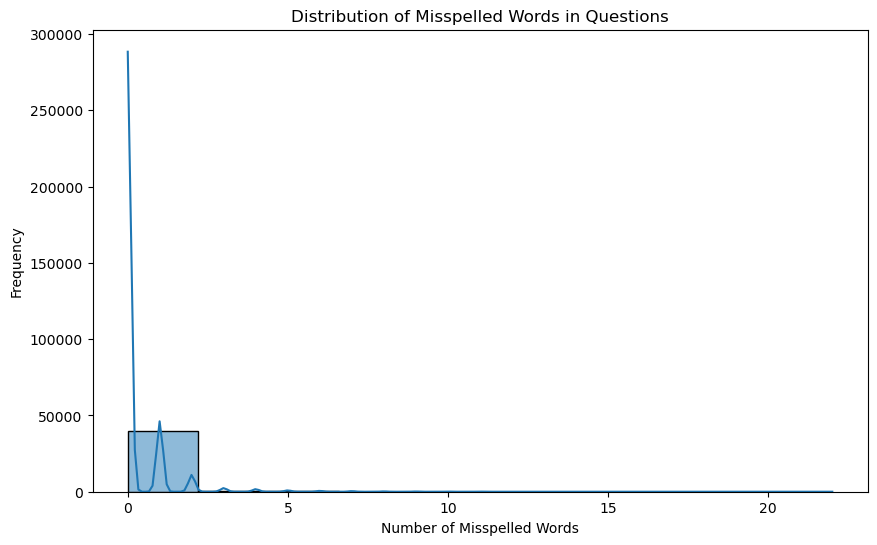

In [ ]:
# Function to check spelling consistency using Spacy
def check_spelling_consistency(text):
    doc = nlp(text)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    misspelled_words = [word for word in words if not nlp.vocab[word].is_alpha]
    return len(misspelled_words), misspelled_words

# Apply the function to the dataset
quest_df[['misspelled_count', 'misspelled_words']] = quest_df['question'].progress_apply(
    lambda x: pd.Series(check_spelling_consistency(x))
)

# Plot the spelling inconsistency distribution
plt.figure(figsize=(10, 6))
sns.histplot(quest_df['misspelled_count'], bins=10, kde=True)
plt.title('Distribution of Misspelled Words in Questions')
plt.xlabel('Number of Misspelled Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
num_misspell = quest_df.misspelled_count.value_counts()
num_misspell

0     33485
1      5365
2      1284
3       278
4       197
5       102
6        65
7        46
8        25
9        18
10       11
11        9
12        7
14        6
13        4
17        1
19        1
15        1
16        1
22        1
Name: misspelled_count, dtype: int64

There are questions that could have as many as 22 misspellings. It's possible that some of these may have been recorded as the equations that were written as part of the question. To confirm we will look at the top number of misspelled questions.

In [ ]:
top_misspell = num_misspell.tail(15).index.to_list()
top_misspell

[5, 6, 7, 8, 9, 10, 11, 12, 14, 13, 17, 19, 15, 16, 22]

In [ ]:
top_misspell_questions = quest_df[quest_df['misspelled_count'].isin(top_misspell)]
top_misspell_questions

category                                           question  \
main_idx                                                                        
904                     ai  How are the reward functions $R(s)$, $R(s, a)$...   
1456                    ai  What is meant by "known" in "A knowledge-base ...   
2163                    ai  Is the "mlpconv" layer in the "Network in Netw...   
3052                    ai  Given statements $A$ and $B$, are the formulae...   
3782                    ai  Which function $(\hat{y} - y)^2$ or $(y - \hat...   
3861                    ai  In YOLO, when is $\mathbb{1}_{i j}^{\mathrm{ob...   
4345                    ai  Why is "-0.5 * torch.sum(1 + sigma - mu.pow(2)...   
4367                    ai  Can we solve an $8 \times 8$ sliding puzzle us...   
4665                    ai  Given an input $x \in R^{1\times d}$ and a net...   
4666                    ai  If the training data are linearly separable, w...   
5778                    ai  YOLOv3 Model Structure: Why is filters = (clas...   
5914                    ai  How do I convert an MDP with the reward functi...   
6366                    ai  What does $r : \mathcal{S} \times \mathcal{A} ...   
6638                    ai  $\frac{P(x_1 \mid y, s = 1) \dots P(x_n \mid y...   
7096                    ai  If the goal of training of a GAN is to have $P...   
7387                    ai  Why is the margin attained with $\Phi=\left[2 ...   
8055                    ai  Meaning of the statement $\forall x \exists y ...   
8081                    ai  What does the notation $p_t = \text{max}_{i<t}...   
8197                    ai  What is the dimension of my output of the form...   
11218                   ai  Why is the hypothesis function $h_{\theta}(x)$...   
12587                   ai  During Backpropagation in LSTM, why is the pre...   
13684                   ai  Connection between the Bellman equation for th...   
14639                   ai  Why doesn't value iteration use $\pi(a \mid s)...   
14672                   ai  Why doesn't the set $\{ -2, +2 \}$ in $E(X) = ...   
15351                   ai  Given two neural networks that compute two fun...   
15868                   ai  Why is the target $r + \gamma \max_{a'} Q(s', ...   
18054                   ai  How can I go from $R(s)$ to $R(s,a)$ in this s...   
18206                   ai  Equivalence of the $Q(s,a)$ and $V(s)$ under o...   
19552                   ai  What is the difference between the notations $...   
19826                   ai  How do we express $q_\pi(s,a)$ as a function o...   
20229                   ai  Why does the size reduce to $6 \times 6$ in th...   
20826                   ai  How to prove $\mathcal H$ with VC dimension $d...   
21232                   ai  Would either $L_1$ or $L_2$ regularisation low...   
21280                   ai  Is it possible to predict $x^2$, $\log(x)$, or...   
22175                   ai  Why do we use $D(x \mid y)$ and not $D(x,y)$ i...   
22618                   ai  Sutton & Barto's notation $V_{t+n}$ in Chapter...   
22987                   ai  What do the notations $\sim$ and $\Delta (A) $...   
23525                   ai  Why is the reward function $\text{reward} = 1/...   
23890                   ai  Shouldn't expected return be calculated for so...   
24014                   ai  Why do we use $X_{I_t,t}$ and $v_{I_t}$ to den...   
24361                   ai  Why does this multiplication of $Q$ and $K$ ha...   
24433                   ai  How can I show that the VC dimension of the se...   
25122                   ai  Given a list of integers $\{c_1, \dots, c_N \}...   
25200                   ai  For episodic tasks with an absorbing state, wh...   
25244                   ai  Why is the equation $r(s', a, s') =\sum_{r \in...   
25994                   ai  How can I get to a final output of shape $224 ...   
27872                   ai  Which NN would you choose to estimate a contin...   
28969                   ai  Calculating tangent v

A lot of the misspelled instances are those that were equation/formula related questions. To get a more representative view of incorrectly spelled instances we will filter out the high noise questions since many of those were equation related content.

In [ ]:
clean_no_noise = quest_df.copy()
clean_no_noise = clean_no_noise[~clean_no_noise['noise_count'].isin(top_noise_char)]
clean_no_noise

category                                           question  \
main_idx                                                               
8              ai  Are there any learning algorithms as powerful ...   
9              ai            Can DQN perform better than Double DQN?   
12             ai  How should I weight the factors that affect th...   
23             ai  Should I use exploration strategy in Policy Gr...   
24             ai         Why are autonomous cars categorized as AI?   
...           ...                                                ...   
40885      sports  What issues arise from spot fixing and match f...   
40887      sports  Walkoff homer, decisive run scores but followi...   
40891      sports                 Women's versus Men's pay in majors   
40894      sports  Consequences if an official interferes with play?   
40910      sports   Championship golf courses with a par-3 18th hole   

           attribution  noise_count  misspelled_count misspelled_words  
main_idx                                                                
8         CC BY-SA 3.0            3                 0               []  
9         CC BY-SA 4.0            1                 0               []  
12        CC BY-SA 4.0            1                 0               []  
23        CC BY-SA 4.0            1                 0               []  
24        CC BY-SA 4.0            1                 0               []  
...                ...          ...               ...              ...  
40885     CC BY-SA 3.0            1                 0               []  
40887     CC BY-SA 3.0            1                 0               []  
40891     CC BY-SA 4.0            2                 2         ['s, 's]  
40894     CC BY-SA 3.0            1                 0               []  
40910     CC BY-SA 3.0            1                 2    [par-3, 18th]  

[40482 rows x 6 columns]

In [ ]:
num_misspell = clean_no_noise.misspelled_count.value_counts()
num_misspell

0     33472
1      5353
2      1232
3       234
4       121
5        46
6        13
7         5
9         3
8         2
10        1
Name: misspelled_count, dtype: int64

In [ ]:
top_misspell = num_misspell[3:5].index.to_list()
top_misspell

[3, 4]

In [ ]:
top_misspell_questions = clean_no_noise[clean_no_noise['misspelled_count'].isin(top_misspell)]
top_misspell_questions

category                                           question  \
main_idx                                                                        
2603                    ai  Each training run for DDQN agent takes 2 days,...   
3451                    ai  In the multi-linear regression, how is the val...   
3699                    ai  Optimal RL agent's representation of 3D-grid d...   
4628                    ai  Reasoning behind $Zero$ validation accuracy in...   
5290                    ai  What does the symbol $\mathbb E$ mean in these...   
5624                    ai  How do we design a neural network such that th...   
5887                    ai  Seq2Seq dialogs predicts only most common word...   
6740                    ai  Why a single trajectory can be used to update ...   
7157                    ai  In 2016, can $1000.00 buy enough operations pe...   
7904                    ai  $\nabla \log \pi$ with respect to some paramet...   
8463                    ai  Why is this variable in equation 2 of the SQAI...   
8607                    ai  What is the intuition behind equations 10, 11 ...   
11316                   ai  ALL OUTPUTS for my neural network return SAME ...   
11501                   ai  Micro average f1_score, None average f1_score ...   
12106                   ai  Tensorflow: Can't overfit training data with b...   
13346                   ai  What exactly are the "parameters" in GPT-3's 1...   
13377                   ai  Why is it useful to define the return as the s...   
13644                   ai  What is the point of using 1D and 2D convoluti...   
13828                   ai  Is the reward following after time step $t+1$ ...   
14133                   ai  Should I use the Threadripper 2920X or Ryzen 7...   
21718                   ai  In this implementation of pix2pix, why are the...   
21983                   ai  Why does my neural network to predict $x$ give...   
22404                   ai  Code freezes and never returns when linear_ker...   
22647                   ai  Does replacing 3x3 filters with 3x1 and 1x3 fi...   
23050                   ai  ‪Can a multi-camera system be used for localiz...   
23283                   ai  Why Monte Carlo epsilon-soft approach cannot c...   
24319                   ai  How can I build a model to approximate the fun...   
26029                   ai  CIFAR-10 can't get above 10% Accuracy with Mob...   
28306                   ai  If the accuracy of my current model is low ($5...   
28390                   ai  Is there a difference between using 1d conv la...   
28899                   ai  Target values of 0.1 for 0 and 0.9 for 1 for s...   
29425                   ai  When past states contain useful information, d...   
30387                   ai                    What is the $\ell_{2, 1}$ norm?   
32168                   ai  How to design an observation(state) space for ...   
32348                   ai  Can a basic CNN (Conv2D, MaxPooling2D, UpSampl...   
32364                   ai  In this VAE formula, why do $p$ and $q$ have t...   
32376                   ai  Can a trained Vid2Vid model be run on AMDs Ryz...   
32510                   ai  Which algorithm is best for a 4*4*4*4 variant ...   
33330                   ai  how to add the pool4 to the 2 x conv7 in FCN-1...   
34105                   ai  Why would a VAE train much better with batch s...   
34560                   ai  Train detector : 300 images with 30 objects or...   
34729                   ai  What is the difference between step_model and ...   
36146                   ai  Is it possible To use GPT-3 with Voice Cloning...   
37689                   ai  Is using a filter of size (1, x, y) on a 3D co...   
38217                   ai  Why does 0.8:0.2 divided dataset have a much g...   
38780                   ai  Why does estimation error increase with $|H|$ ...   
39397                   ai          What are sim2sim, sim2real and real2real?   
39500                   ai  About synced and comb

Many of the detected misspellings include numbers that have been combined with letters (e.g. 2nd), numbers themselves (e.g. 2019), equations/formulae, words combined with special characters (e.g. Lyman‐α, weak-), acronyms (e.g. GPT-3) and technical syntax (e.g. MaxPooling2D, sklearn.metrics.pairwise). These are very context/domain specific terminology that may only be specific to a particular category. Since there are a lot of these cases it's good to note these during model selection. For now these will be left as is.

## Text Characteristics
We'd also like to examine the vocabulary size and frequency distribution of words. Other analysis could also include exploring n-grams and to identify frequently ocurring terms and phrases. This should help with understanding the diveristy and sparsity of the text data.

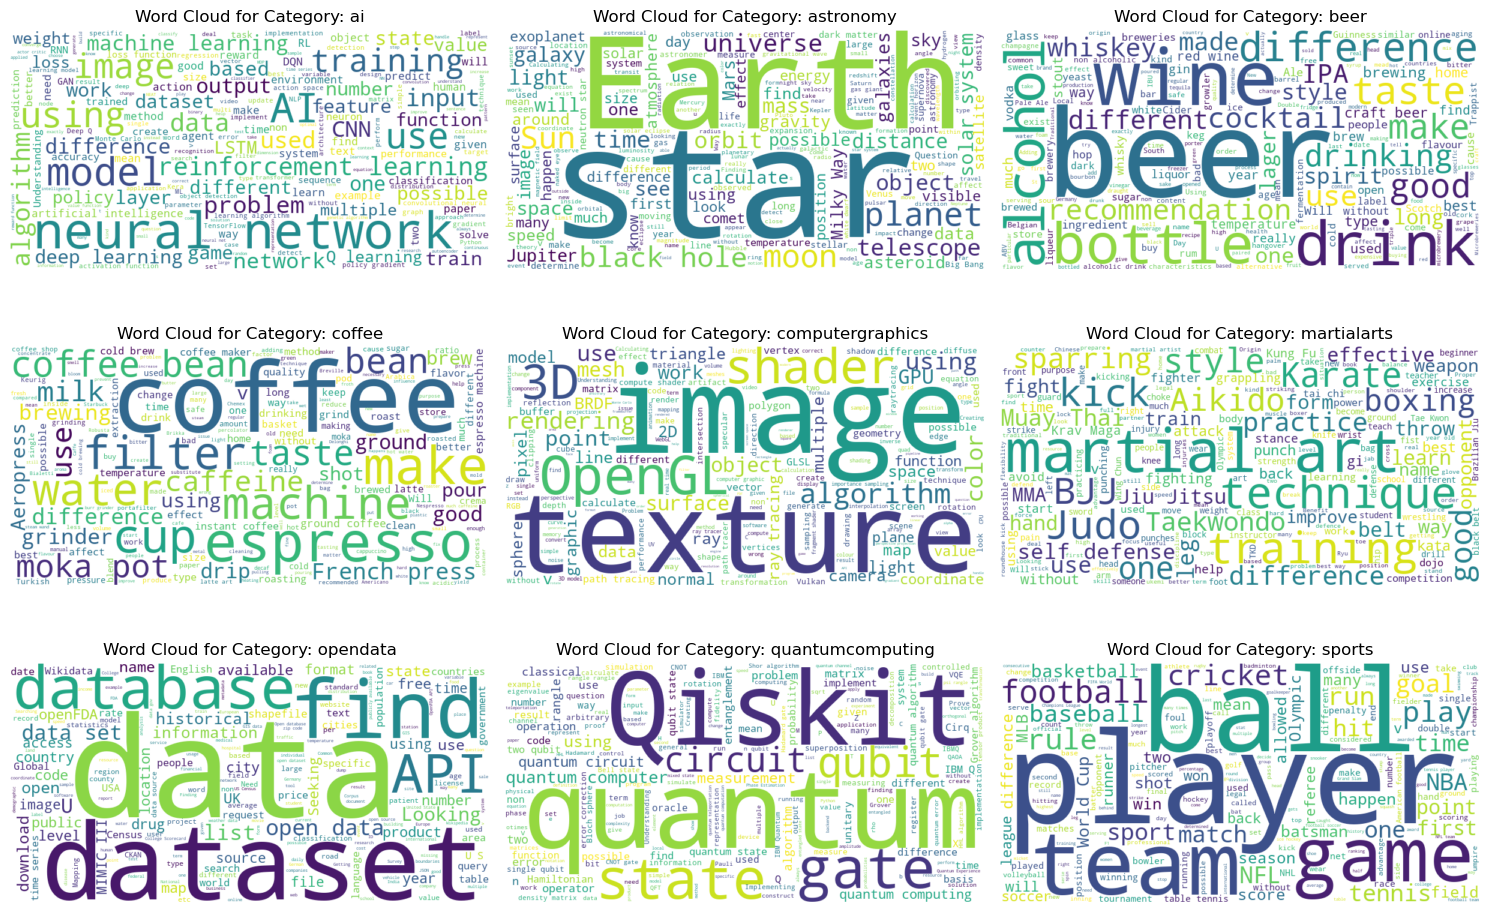

In [ ]:
# Unique categories
categories = quest_df['category'].unique()

# Plot settings
plt.figure(figsize=(15, 10))

# Loop through each category
for i, category in enumerate(categories):
    plt.subplot(3, 3, i + 1)  # Adjust subplot grid size based on the number of categories
    category_text = ' '.join(quest_df[quest_df['category'] == category]['question'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)

    # Plot the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')

plt.tight_layout()
plt.show()

It appears a lot of the key terminology that comes most frequently across the different categories are relatively distinct from each other. This is good possible indication that the usage of certain key words should allow for relatively effective classification performance. To further confirm this we can also explore the most common combination of words (n-grams) that occur across the categories.

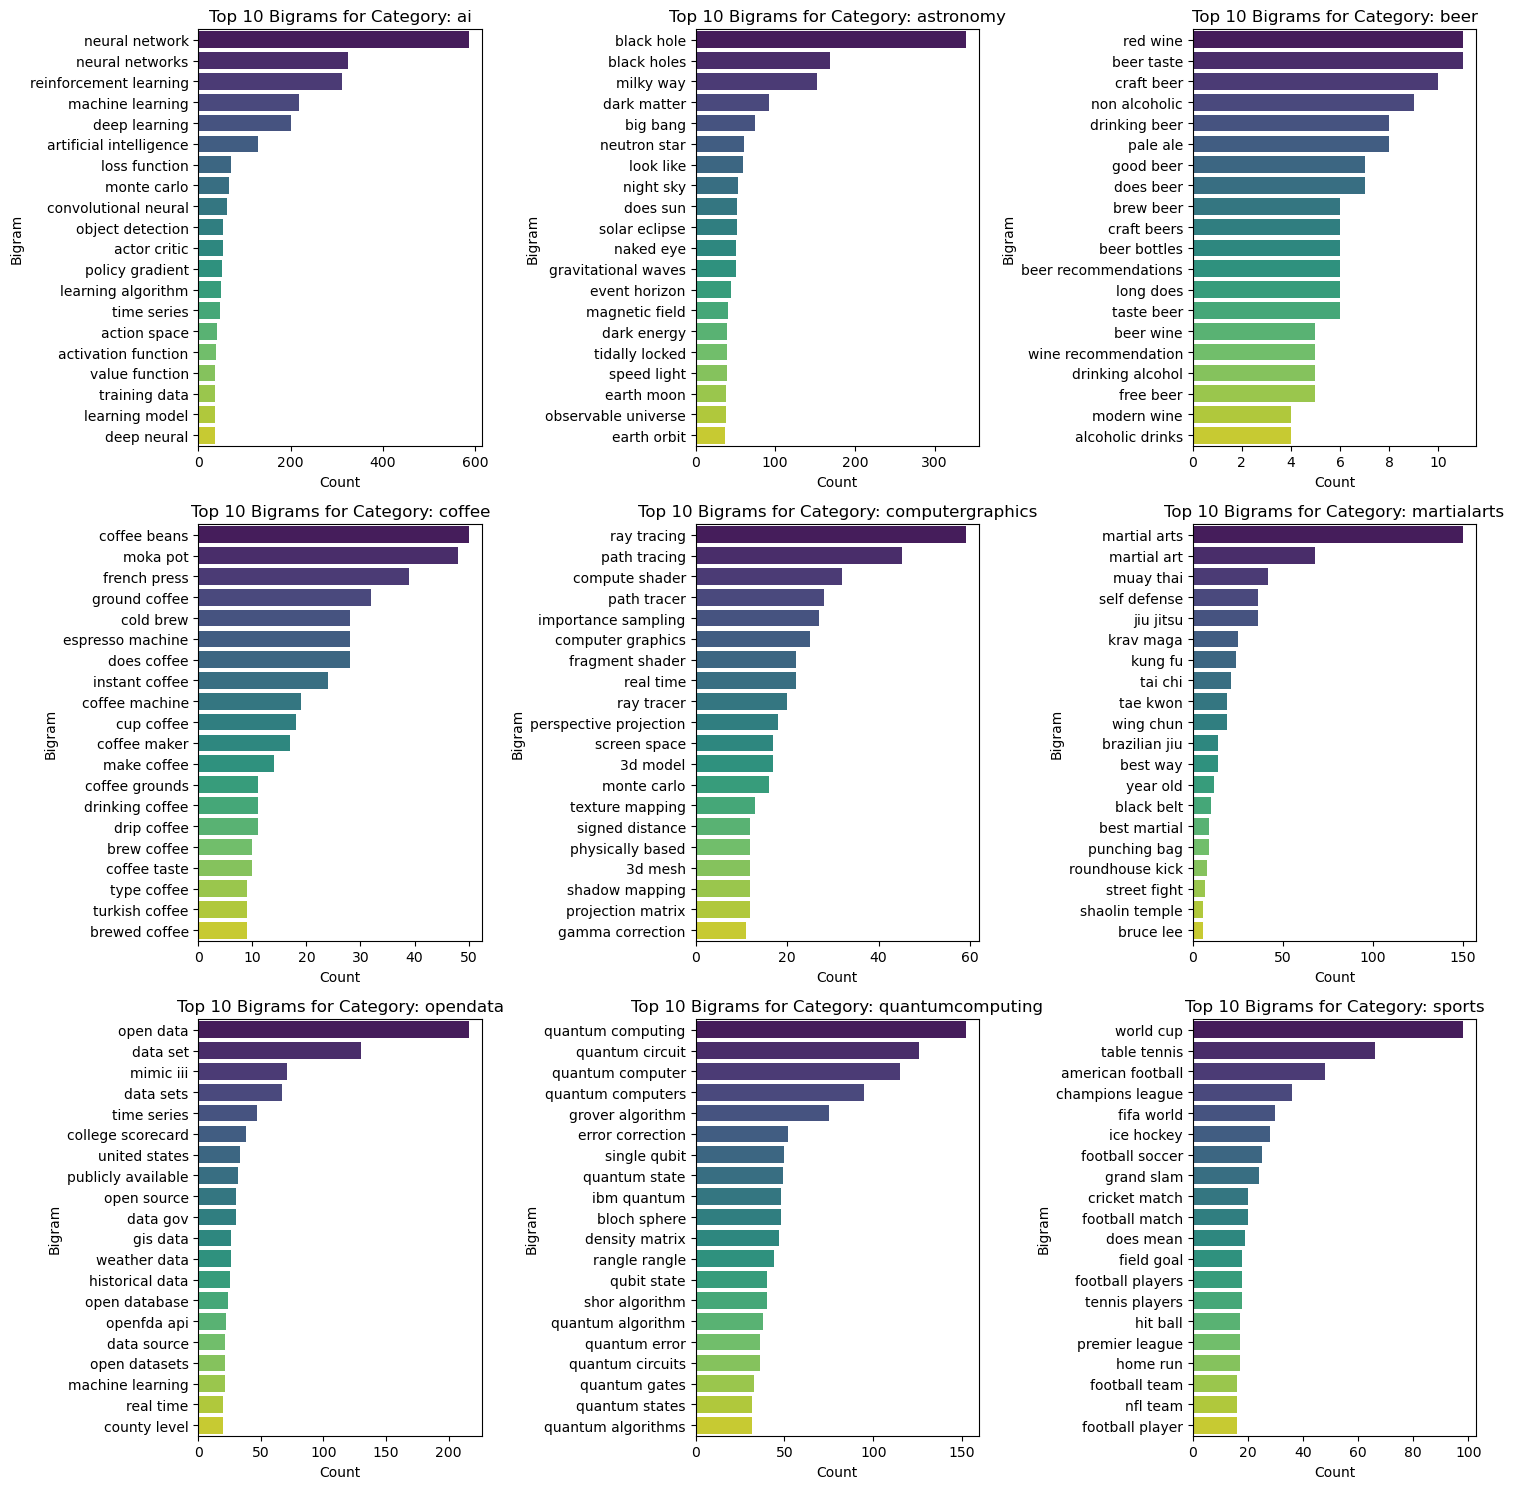

In [ ]:
# Function to get top n-grams
def get_top_ngrams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Unique categories
categories = quest_df['category'].unique()

# Plot settings
plt.figure(figsize=(15, 15))

# Loop through each category
for i, category in enumerate(categories):
    plt.subplot(3, 3, i + 1)  # Adjust subplot grid size based on the number of categories
    category_text = quest_df[quest_df['category'] == category]['question']

    # Get top bigrams
    top_bigrams = get_top_ngrams(category_text, ngram_range=(2, 2), n=20)

    # Convert to DataFrame for visualization
    bigrams_df = pd.DataFrame(top_bigrams, columns=['bigram', 'count'])

    # Plot the top bigrams
    sns.barplot(x='count', y='bigram', data=bigrams_df, palette='viridis')
    plt.title(f'Top 10 Bigrams for Category: {category}')
    plt.xlabel('Count')
    plt.ylabel('Bigram')

plt.tight_layout()
plt.show()

Simiarly, we can observe that word pairs are rather distinct between the categories. However, while this is a good indication we need to consider how representative this is across the questions in the dataset. That is let's investigate the number of questions that contain these top n-grams.

Processing Categories: 100%|█████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.02it/s]


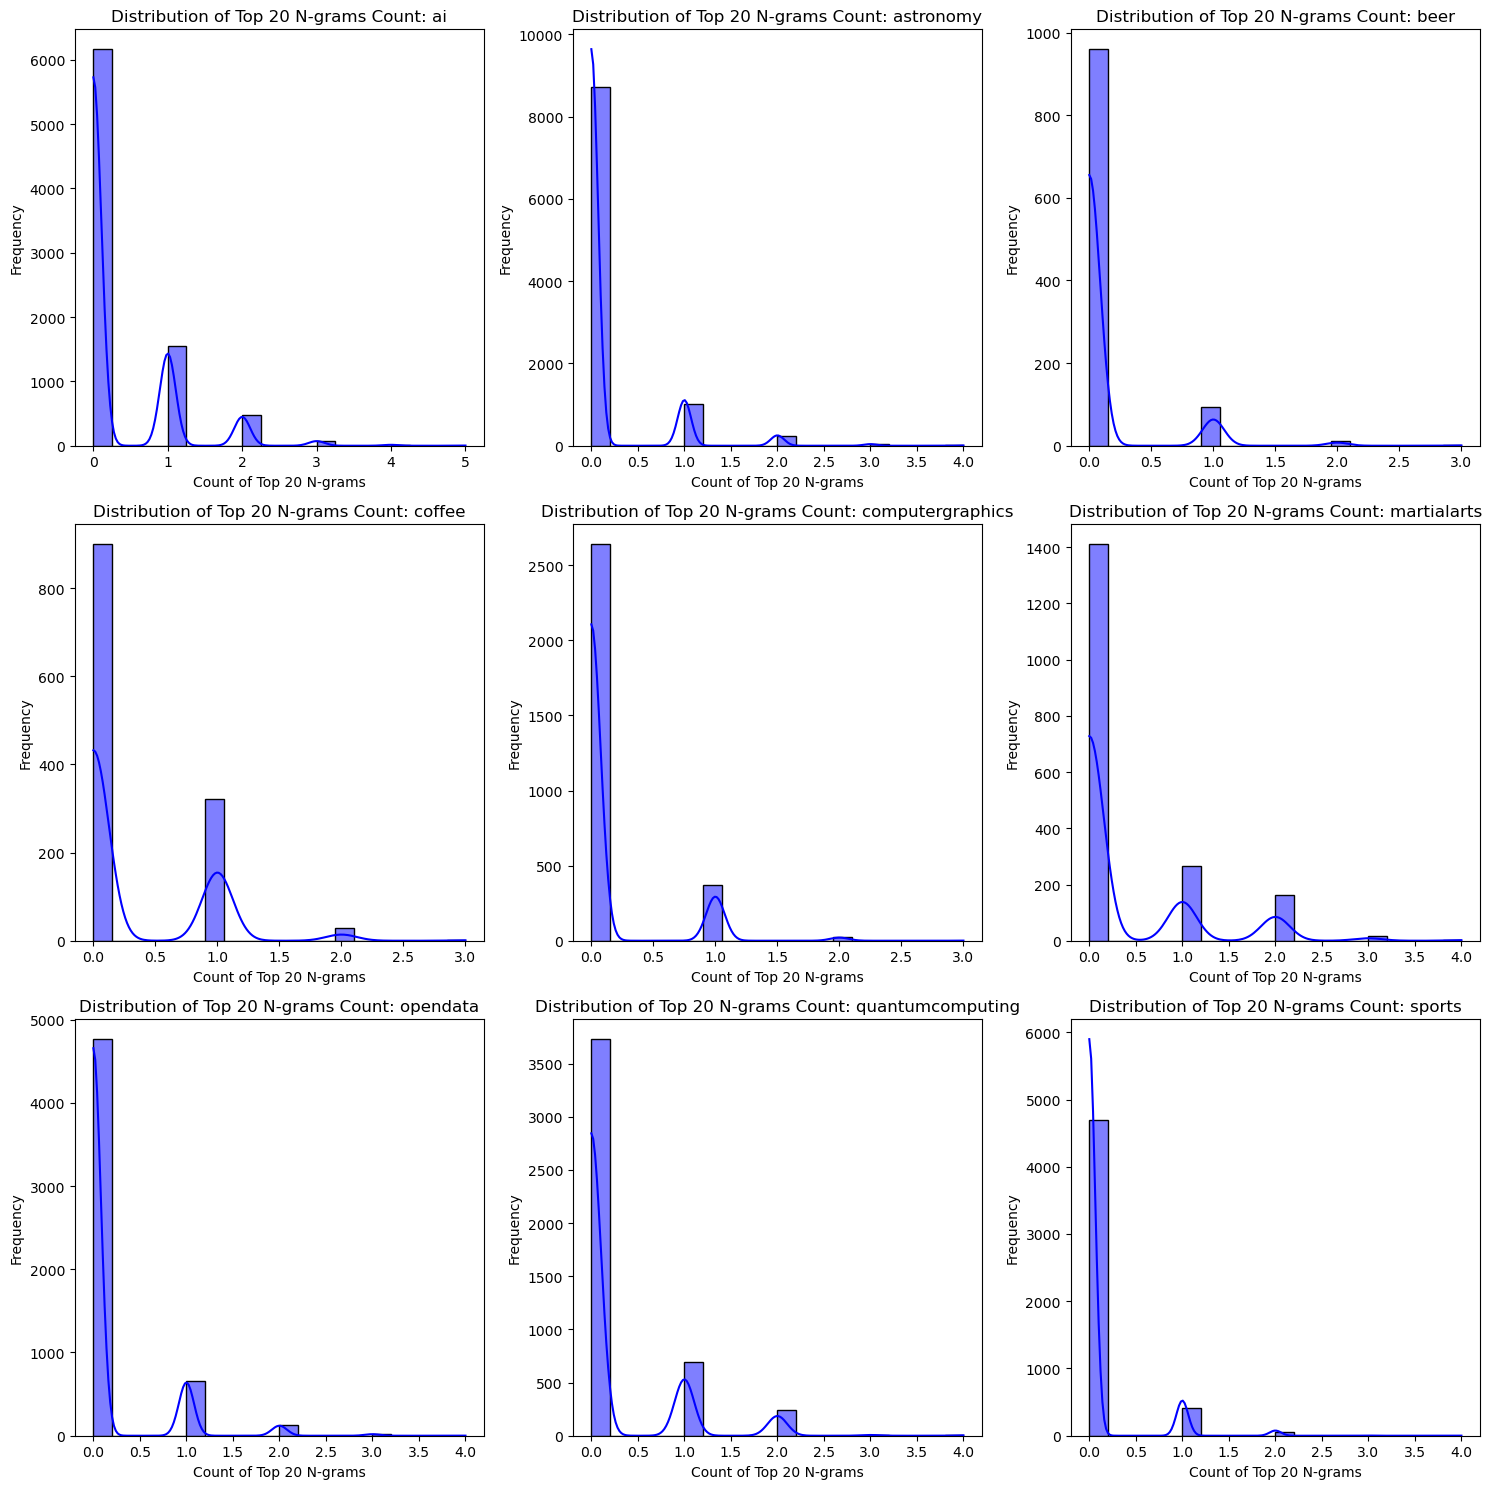

In [ ]:
# Function to count occurrences of top n-grams in a question
def count_ngrams_in_text(text, top_ngrams):
    text = text.lower()
    count = 0
    for ngram, _ in top_ngrams:
        count += text.count(ngram)
    return count

# Process each category
categories = quest_df['category'].unique()

# Create an empty DataFrame to store results
results = []

# Loop through each category to get top 20 n-grams
for category in tqdm(categories, desc='Processing Categories'):
    category_text = quest_df[quest_df['category'] == category]['question']

    # Get top 20 n-grams for the current category
    top_ngrams = get_top_ngrams(category_text, ngram_range=(2, 2), n=20)

    # Count occurrences in each question for the current category
    quest_df.loc[quest_df['category'] == category, 'top_20_ngrams_count'] = quest_df[quest_df['category'] == category]['question'].apply(lambda text: count_ngrams_in_text(text, top_ngrams))

    # Store results
    results.append(quest_df[quest_df['category'] == category])

# Combine results into one DataFrame
result_df = pd.concat(results)

# Plot histograms for each category
plt.figure(figsize=(15, 15))

# Loop through each category to plot histogram
for i, category in enumerate(categories):
    plt.subplot(3, 3, i + 1)  # Adjust subplot grid size based on the number of categories
    category_data = result_df[result_df['category'] == category]

    # Plot histogram
    sns.histplot(category_data['top_20_ngrams_count'], bins=20, kde=True, color='blue')
    plt.title(f'Distribution of Top 20 N-grams Count: {category}')
    plt.xlabel('Count of Top 20 N-grams')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

It appears a majority of the questions don't even contain many of the top n-grams that were found above. This suggests that the top n-grams may not be representative of the content of questions in the dataset. One possibility might be due to the unquieness of these n-grams, and it might be worth comparing the occurance of top word counts instead.

Processing Categories: 100%|█████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.46it/s]


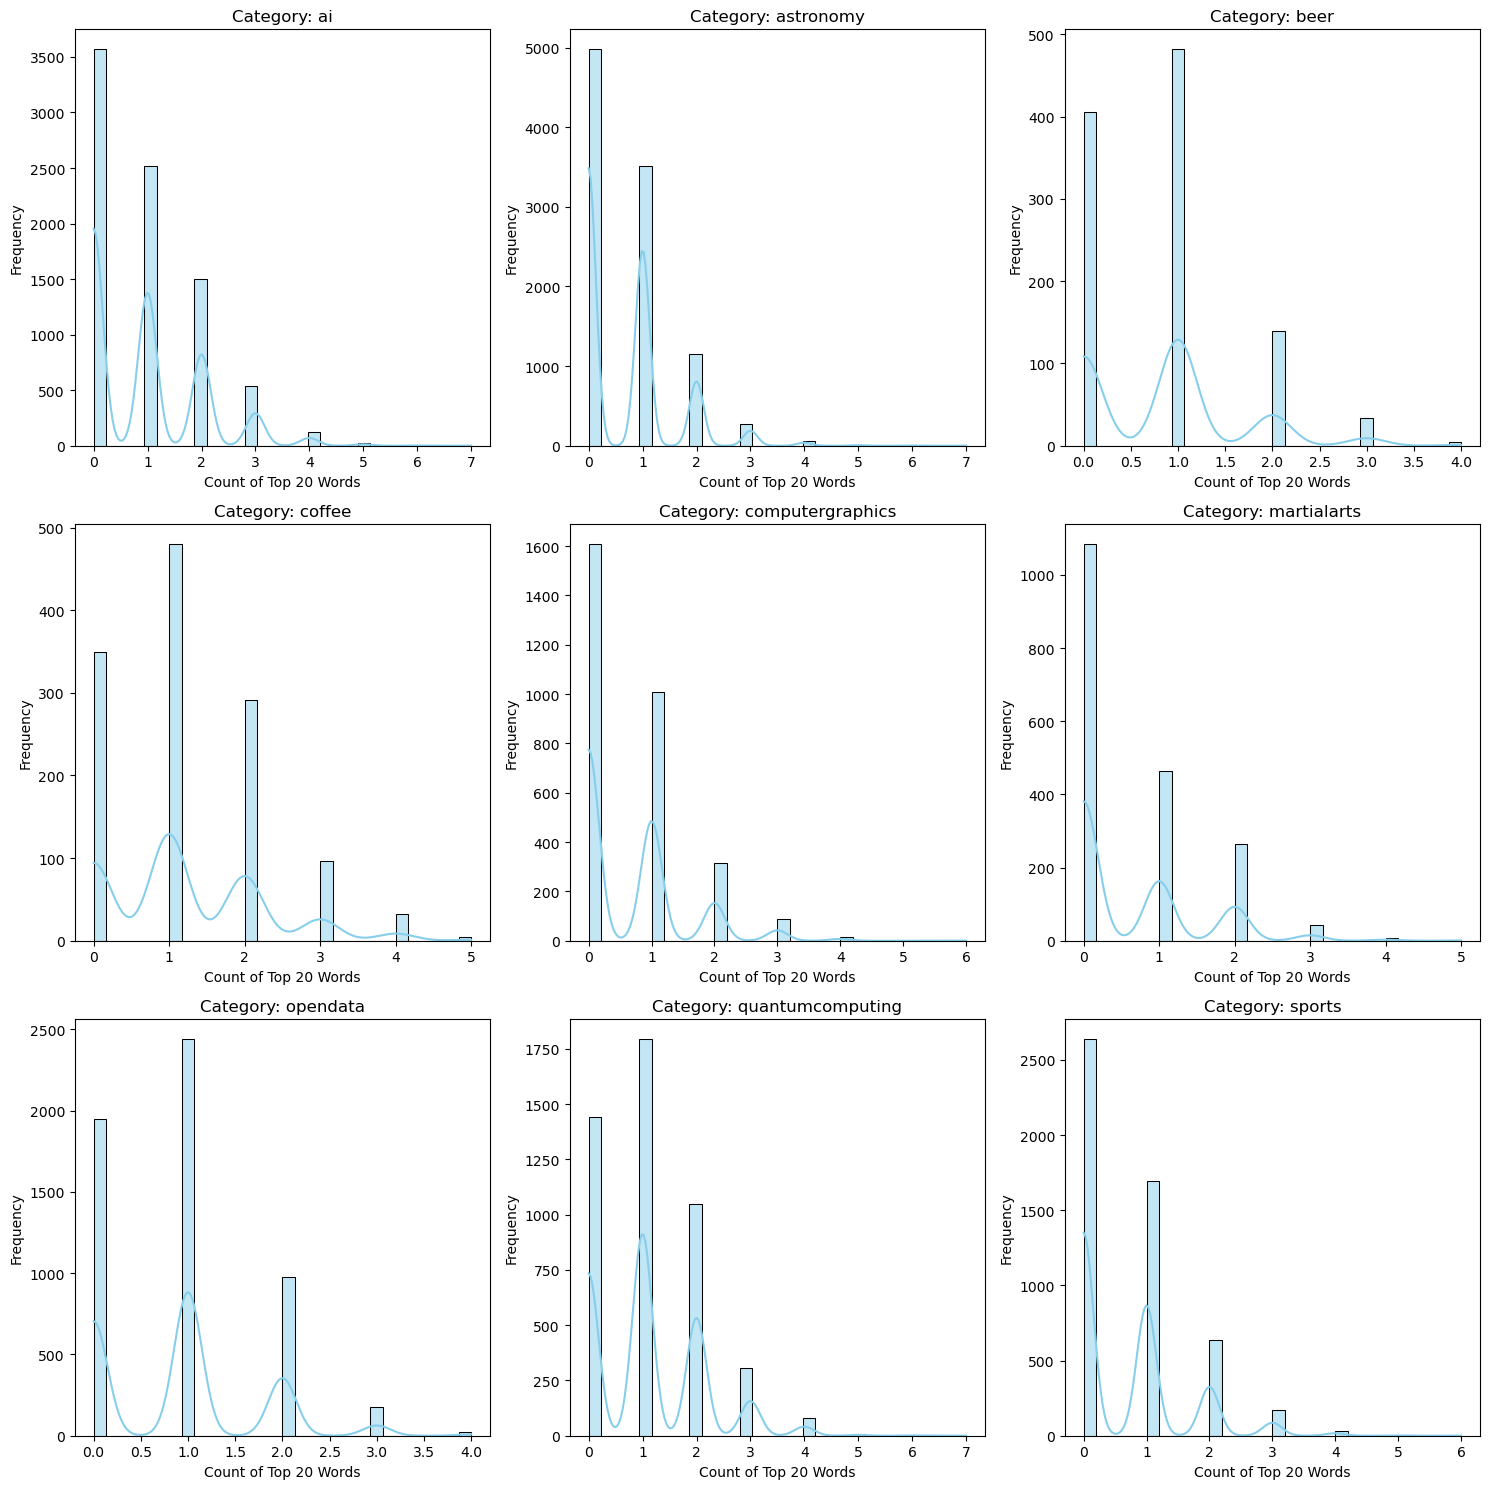

In [ ]:
# Function to get top words
def get_top_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Function to count occurrences of top words in a question
def count_words_in_text(text, top_words):
    text = text.lower()
    count = 0
    for word, _ in top_words:
        count += text.split().count(word)
    return count

# Process each category
categories = quest_df['category'].unique()

# Set up plot grid
num_categories = len(categories)
fig, axes = plt.subplots(nrows=(num_categories + 2) // 3, ncols=3, figsize=(15, (num_categories + 2) // 3 * 5))
axes = axes.flatten()

# Loop through each category to get top 20 words and plot histograms
for i, category in enumerate(tqdm(categories, desc='Processing Categories')):
    category_text = quest_df[quest_df['category'] == category]['question']

    # Get top 20 words for the current category
    top_words = get_top_words(category_text, n=20)

    # Count occurrences in each question for the current category
    quest_df.loc[quest_df['category'] == category, 'top_20_words_count'] = quest_df[quest_df['category'] == category]['question'].apply(lambda text: count_words_in_text(text, top_words))

    # Plot histogram for the current category
    sns.histplot(quest_df[quest_df['category'] == category]['top_20_words_count'], bins=30, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Category: {category}')
    axes[i].set_xlabel('Count of Top 20 Words')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

This shows a bit more promise in how word frequency could be a bit more representative of the questions per category. However, the fact that nearly half of the questions in each category do not feature any of the top 20 words raises concerns about the effectiveness of using word frequency alone for classification. This suggests that although certain words are strongly associated with specific categories, many questions may use different vocabulary not represented by the top 20 words. Relying solely on word semantics could therefore result in incomplete or biased classifications.

These insights will be crucial for guiding our modeling decisions.

# Modelling
For textual classification there are a number of predictive techniques that can be used, each with its own advantages and use cases. The following are a couple approaches:

- **Rule-Based Approaches**: Uses predefined lists of keywords associated with each category. This also includes pattern matching with regular expressions to identify specific text patterns associated with the categories.
- **Feature Extraction**: This may include comparing categories against a Bag of Words (BoW), TF-IDF (Term Frequency-Inverse Document Frequency) and word embeddings.
- **Deep Learning Approaches**: While RNNs are traditional deep learning techniques for textual processing, there are more powerful models such as transformers.

## Summary: Data Characteristics
Based on our observations in the data, it appears that the dataset contains a variety of content types, including equations, technical terminology, and domain-specific acronyms, which can introduce noise and complexity into text classification tasks. To summarise, these are key characteristics that we observed in the data:

**1. Noise Handling**
- Equations and technical terms were identified as noise characters. Typically removing noise can help with performance, however, removing these could strip the text of crucial information.
- Misspellings were found to hold contextual and domain-specific meaning, for example we had misspellings detected as follows: numbers that have been combined with letters (e.g. 2nd), numbers themselves (e.g. 2019), equations/formulae, words combined with special characters (e.g. Lyman‐α, weak-), acronyms (e.g. GPT-3) and technical syntax (e.g. MaxPooling2D, sklearn.metrics.pairwise). Therefore, these terms are significant in some categories and should not be disregarded.

**2. Vocabulary Representation**
- Top n-grams and words may not cpature the diversity of vocabulary across questions, indicating the need for a more comprehensive representation of text features.

**3. Contextual Understandings**
- The model needs to understand context to differentiate between categories, especially when questions contain equations or technical syntax.

## Evaluating the Different Modelling Approaches
Considering these findings, **transformers** appear the most promising for this classification problem. Transformers are designed to understand the context of words within a sentence, and hence will treat equations, technical terms, acronyms and formulae as part of the context, ensuring important syntactic elements are not lost. This is since these levearage the following techniques:
- **Attention Mechanism**: The self-attention mechanism in transformers allows the model to focus on relevant parts of the text, making them robust to noise and able to handle diverse vocabulary.
- **Pre-trained Knowledge**: Transformers are pre-trained on large datasets, leveraging their extensive knolwedge to understand and classify complex and domain-specific text.
- **Handling Complex Syntax**: Transformers are capable of understanding and retaining the strcture and syntax of text, which is essential for interpreting technical content accurately.

Although it's natural for us to skip directly to the most powerful approach (such as transformers) that is likely to give the most performative results, it remains crucial that we evaluate the potential of alternative methods. This is because, in principle, it is always better to use a simpler alternative if it can achieve the same results as a more complex model. Therefore, let's evaluate the other methods in comparison to transformers:

- **Rule-Based Approaches**:
    - Keyword matching relies on the presence of specific words to classify text, which can be problematic when dealing with domain-specific terms, equations, or diverse vocabulary.
    - Moreover, regular expressions are good for pattern matching but are inflexible and cannot capture the broader context or nuances of language. They are also hard to maintain and scale for large, diverse datasets.

- **Feature Extraction Techniques**:
    - BoW ignores word order and context, treating each word as independent. This limits its ability to understand the meaning of text.
    - On the other hand, while TF-IDF adjusts for the importance of words, it still does not capture the context or semantic relationships between words.
    - Moreover, word embeddings (Word2Vec, GloVe) might capture some semantic relationships, however do not model the full context within sentences.  
    
- **Deep Learning Approaches**:
    - RNNs are designed to handle sequential data and are capable of learning dependencies and relationships within the data, which make it ideal for context specific textual classification.
    - Traditional RNNs suffer from vanishing gradient problems, making it difficult to capture long-range dependencies. Thus, the model may struggle with very long sequences and maintaining context over long distances compared to transformers.
    - However, given that the current problem is classifying questions that are short-form texts, the above short-falls might not be problematic. In fact, this makes RNNs potentially advantageous as the model is less likely to be complex and more computationally efficient than transformers, epecially since it's dealing with shorter sequences.
    
Therefore, the most comparative model for this classification problem is the RNN and depending on the modelling decisions we make with this technique this could be a less complex alternative to transformers.

As a result, the RNN and transformer techniques will be compared to identify the most optimal model selection for this problem.

## Model Data Prep
Before preparing the evaluation workflows we need to ensure the data is prepared correctly. Key considerations in this case is ensuring the dataset has a train-test split and that the dataset is stratified between the split datasets:

- The **train-test split** is crucial for assessing how well the model would perform on a new unseen set of data. For the transformer case this is not as necessary since the model is already pre-trained, however for the RNN implementation the train-test split is required as it requires training. For consistency the train-test split is considered for both implementations during evaluation.  

- Given that we observed class imbalances in our initial data analysis **stratification** is important since it ensures a more representative sample. As a result, this prevents bias/underrepresentation of certain groups in model evaluation and provides a more accurate reflection of a model's generalisation ability.

In [ ]:
# Prepare the data
X = quest_df['question'].values
y = quest_df['category'].values
classes = quest_df['category'].unique().tolist()

In [ ]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Stratified K-Folds cross-validator for training data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Transformer Model Evaluation


In [ ]:
# Initialize classifier
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Since the transformer model takes approx. 1 sec to process each question it would take almost 10 hours to perform a full cross-validation. Since, we want to obtain quick results we will take a 5% subset of the training data and perform evaluation on this set (30 mins).

In [ ]:
# Create a stratified 5% subset of the training set
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.95, stratify=y_train, random_state=42)

In [ ]:
# Evaluate on the 5% training subset
train_subset_results = []
for question, actual_category in tqdm(zip(X_train_subset, y_train_subset), total=len(X_train_subset)):
    result = classifier(question, classes)
    pred_category = result['labels'][0]  # Get the top predicted label
    scores_with_labels = list(zip(result['labels'], result['scores']))
    train_subset_results.append([question, actual_category, pred_category, scores_with_labels])

# Convert results to DataFrame
train_subset_df = pd.DataFrame(train_subset_results, columns=['Question', 'Actual Category', 'Predicted Category', 'Scores with Labels'])

# Calculate metrics for the 5% training subset
y_pred_train_subset = train_subset_df['Predicted Category'].values
train_subset_confusion_matrix = confusion_matrix(y_train_subset, y_pred_train_subset, labels=classes)
train_subset_f1_score = f1_score(y_train_subset, y_pred_train_subset, average='weighted')
train_subset_precision = precision_score(y_train_subset, y_pred_train_subset, average='weighted')
train_subset_recall = recall_score(y_train_subset, y_pred_train_subset, average='weighted')
train_subset_accuracy = accuracy_score(y_train_subset, y_pred_train_subset)

100%|██████████████████████████████████████████████████████████████████████████████| 1636/1636 [30:22<00:00,  1.11s/it]


In [ ]:
# Display results
print("5% Training Subset Evaluation Metrics:")
print(f"F1-Score: {train_subset_f1_score}")
print(f"Precision: {train_subset_precision}")
print(f"Recall: {train_subset_recall}")
print(f"Accuracy: {train_subset_accuracy}")

5% Training Subset Evaluation Metrics:
F1-Score: 0.5907799313310709
Precision: 0.8031675754997847
Recall: 0.5592909535452323
Accuracy: 0.5592909535452323


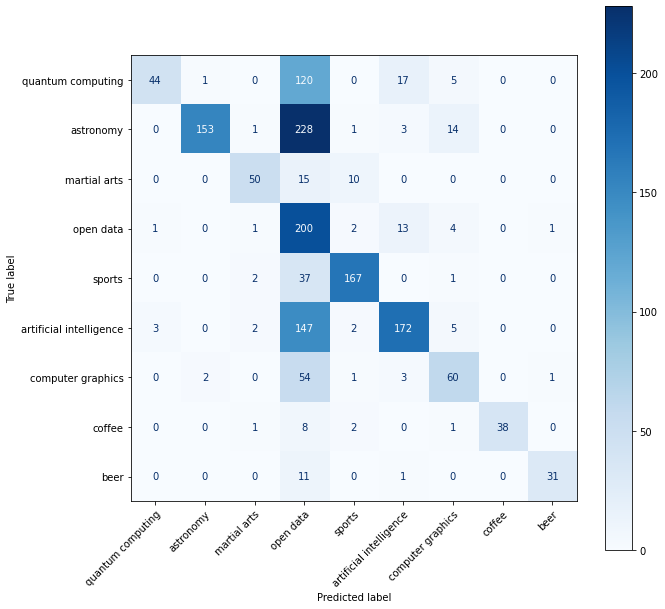

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=train_subset_confusion_matrix, display_labels=classes)
disp.plot(cmap='Blues', ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

It appears as though there might be many ambiguities between "open data" and other labels. This is understandable given that an individual may inquire about a dataset from various domains. Therefore, it might be worth considering making the category label more representative of what the questions represent such as "sourcing data". Since "open data" might refer to any concept that relates to data.

In [ ]:
# Temporarily set the option to display the full length of each cell
with pd.option_context('display.max_colwidth', None):
    # Convert the DataFrame to HTML
    html_output = train_subset_df[train_subset_df['Predicted Category']=='open data'].to_html()

# Display the HTML output
from IPython.core.display import display, HTML
display(HTML(html_output))

A brief inspection of the results and it appears that the correct category is usually the second highest score. Therefore, this augmentation of the category name could possibly improve model performance.

In [ ]:
# Prepare the data
remap_dict = {'open data':'sourcing data'}
quest_df_aug = quest_df.copy()
quest_df_aug['category'] = quest_df_aug['category'].replace(remap_dict)

X_aug = quest_df_aug['question'].values
y_aug = quest_df_aug['category'].values
classes = quest_df['category'].unique().tolist()

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, stratify=y, random_state=42)

# Create a stratified 5% subset of the training set
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.95, stratify=y_train, random_state=42)

In [ ]:
classes_aug = quest_df_aug['category'].unique().tolist()

In [ ]:
# Evaluate on the 5% training subset
train_subset_results = []
for question, actual_category in tqdm(zip(X_train_subset, y_train_subset), total=len(X_train_subset)):
    result = classifier(question, classes_aug)
    pred_category = result['labels'][0]  # Get the top predicted label
    scores_with_labels = list(zip(result['labels'], result['scores']))
    train_subset_results.append([question, actual_category, pred_category, scores_with_labels])

# Convert results to DataFrame
train_subset_df = pd.DataFrame(train_subset_results, columns=['Question', 'Actual Category', 'Predicted Category', 'Scores with Labels'])

# Calculate metrics for the 5% training subset
y_pred_train_subset = train_subset_df['Predicted Category'].values
train_subset_confusion_matrix = confusion_matrix(y_train_subset, y_pred_train_subset, labels=classes_aug)
train_subset_f1_score = f1_score(y_train_subset, y_pred_train_subset, average='weighted')
train_subset_precision = precision_score(y_train_subset, y_pred_train_subset, average='weighted')
train_subset_recall = recall_score(y_train_subset, y_pred_train_subset, average='weighted')
train_subset_accuracy = accuracy_score(y_train_subset, y_pred_train_subset)

100%|██████████████████████████████████████████████████████████████████████████████| 1636/1636 [30:40<00:00,  1.13s/it]


In [ ]:
# Display results
print("5% Training Subset Evaluation Metrics:")
print(f"F1-Score: {train_subset_f1_score}")
print(f"Precision: {train_subset_precision}")
print(f"Recall: {train_subset_recall}")
print(f"Accuracy: {train_subset_accuracy}")

5% Training Subset Evaluation Metrics:
F1-Score: 0.5398024270503534
Precision: 0.8004084180862541
Recall: 0.5158924205378973
Accuracy: 0.5158924205378973


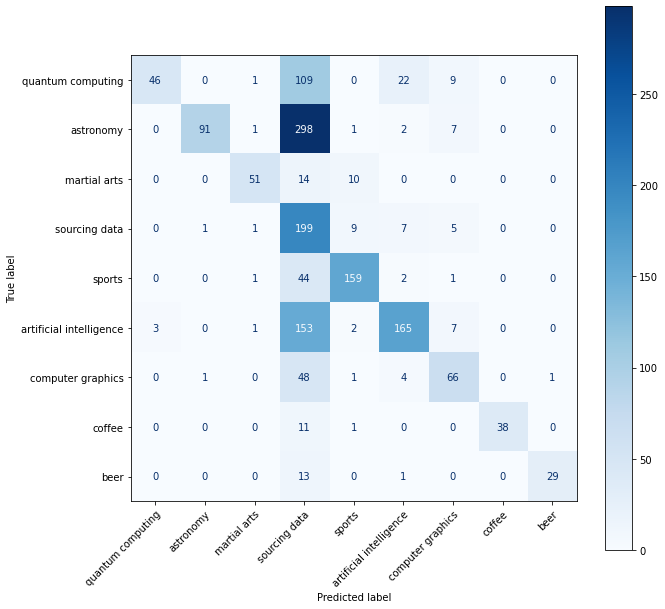

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=train_subset_confusion_matrix, display_labels=classes_aug)
disp.plot(cmap='Blues', ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

Unfortunately, we get similar results where the "open data"/"sourcing data" column is ambigious against other contexts. It may be worth looking into transformer fine tuning, however, lets first evaluate RNN performances as they might offer a more performant and efficient potential to solve the classification problem.

## RNN Model Evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Unlike the transformer the RNN model requires the raw text to be processed before it can be used by the model. The following encodes the text.

In [ ]:
# Initialise the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to the same length
max_seq_length = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

An RNN model can be built using LSTM or GRU layers, which are capable of learning sequential patterns in the data. We will compare between these two layers and select based on which achieves the most optimal performance.
### LSTM Model Evaluation

In [ ]:
# Define model parameters
embedding_dim = 100

# Build the RNN model
model_lstm = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_seq_length),
    LSTM(64, return_sequences=False),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_lstm = model_lstm.fit(
    X_train_pad,
    y_train_enc,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
819/819 [==============================] - 22s 25ms/step - loss: 0.8405 - accuracy: 0.7239 - val_loss: 0.3593 - val_accuracy: 0.8926
Epoch 2/5
819/819 [==============================] - 22s 27ms/step - loss: 0.1741 - accuracy: 0.9499 - val_loss: 0.2945 - val_accuracy: 0.9070
Epoch 3/5
819/819 [==============================] - 21s 26ms/step - loss: 0.0605 - accuracy: 0.9837 - val_loss: 0.3416 - val_accuracy: 0.9011
Epoch 4/5
819/819 [==============================] - 22s 27ms/step - loss: 0.0333 - accuracy: 0.9915 - val_loss: 0.3715 - val_accuracy: 0.9010
Epoch 5/5
819/819 [==============================] - 22s 27ms/step - loss: 0.0171 - accuracy: 0.9955 - val_loss: 0.4096 - val_accuracy: 0.9005


In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

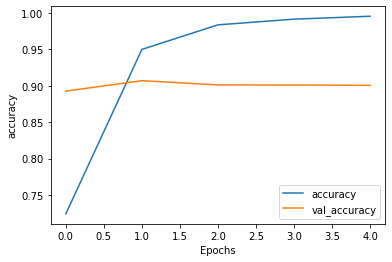

In [ ]:
plot_graphs(history_lstm, "accuracy")

Comparing the validation accuracies between the transformer and RNN, the RNN achieves significantly better performance with a higher validation accuracy. Let's now consider the GRU implementation and evaluate if it could be a better alternative.
### GRU Model Evaluation

In [ ]:
# Define model parameters
embedding_dim = 100

# Build the GRU model
model_gru = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_seq_length),
    GRU(64, return_sequences=False),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_gru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_gru = model_gru.fit(
    X_train_pad,
    y_train_enc,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
819/819 [==============================] - 20s 22ms/step - loss: 0.8095 - accuracy: 0.7341 - val_loss: 0.3497 - val_accuracy: 0.8937
Epoch 2/5
819/819 [==============================] - 21s 26ms/step - loss: 0.1818 - accuracy: 0.9478 - val_loss: 0.3230 - val_accuracy: 0.9018
Epoch 3/5
819/819 [==============================] - 20s 25ms/step - loss: 0.0700 - accuracy: 0.9802 - val_loss: 0.3563 - val_accuracy: 0.9007
Epoch 4/5
819/819 [==============================] - 21s 26ms/step - loss: 0.0311 - accuracy: 0.9914 - val_loss: 0.3868 - val_accuracy: 0.8993
Epoch 5/5
819/819 [==============================] - 20s 25ms/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.4151 - val_accuracy: 0.9002


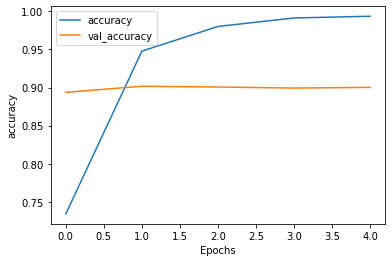

In [ ]:
plot_graphs(history_gru, "accuracy")

 Given that the GRU layer achieves similar results, it might be the most optimal modelling choice for this classification problem. This is largely because the GRU layer is simpler, and thus provides several benefits, including improved efficiency, faster training, and reduced memory usage. (Hence better realtime potential as well)

Let's proceed to the final stages where we evaluate our most optimal model selection (GRU layer RNN) against the test set.

In [ ]:
# Predict probabilities
y_pred_probs = model_gru.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

256/256 [==============================] - 1s 4ms/step


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)

# Compute metrics
accuracy = accuracy_score(y_test_enc, y_pred)
report = classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Extract metrics from the report
avg_precision = np.mean([report[label]['precision'] for label in label_encoder.classes_])
avg_recall = np.mean([report[label]['recall'] for label in label_encoder.classes_])
avg_f1 = np.mean([report[label]['f1-score'] for label in label_encoder.classes_])

print(f'Accuracy: {accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1-Score: {avg_f1:.4f}')

Accuracy: 0.8950
Average Precision: 0.8873
Average Recall: 0.8765
Average F1-Score: 0.8815


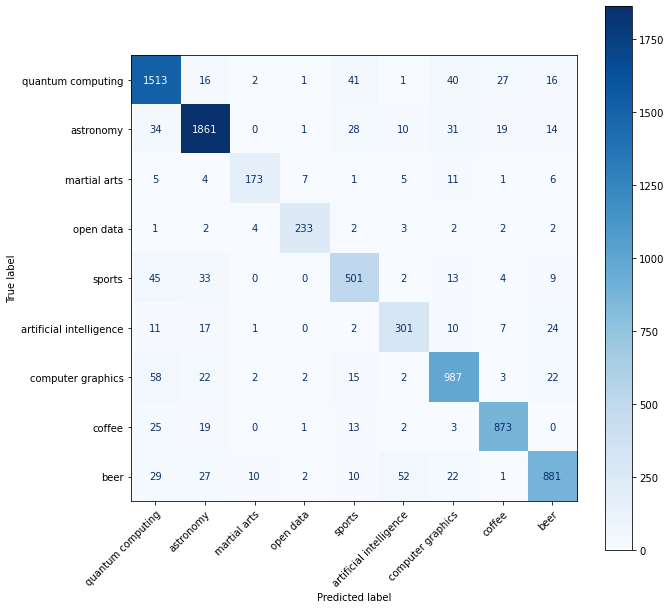

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

The high precision, recall and F1-score values, indicate the model performs well in identifying positive instances and balancing false positives and false negatives. Although, this is very promising there are a few other key considerations regarding performance:

1. **Overfitting Signs**: The training loss consistently decreases, while the validation loss increases over epochs, suggesting potential overfitting. The training accuracy is improving, but validation accuracy starts to decline after Epoch 2.
2. **Test Set Performance**: The test set accuracy is slightly lower than the validation accuracy, which is typical and indicates that the model is generalizing well but might benefit from further tuning to reduce overfitting.

Thus, it would be worth looking into regularisation techniques, early stopping and hyperparameter tuning in future modelling.

Overall the GRU RNN model shows strong performance, but addressing the overfitting and fine-tuning could lead to even better results.

# Conclusions
Following this model evaluation the transformer model, while capable of handling complex data, it faced challenges with its high processing time and limited gains in performance:
- **Initial Metrics**: F1-Score of 0.591, Precision of 0.803, Recall of 0.559, Accuracy of 0.559
- **Post-Category Change Metrics**: F1-Score of 0.540, Precision of 0.800, Recall of 0.516, Accuracy of 0.516

The results above suggest that the ambiguities in the "open data" category might be affecting overall performance. Moreover, the impracticality of validating against the entire dataset, diminishes the feasibility of further exploring transformers as a viable option for this text classification problem.

On the other hand, RNN models, specifically GRU, demonstrated robust performance and efficiency:
- **GRU Final Test Set Results**: Accuracy of 0.8950, Average Precision of 0.8873, Average Recall of 0.8765, Average F1-Score of 0.8815
- **LSTM Performance**: Comparable high accuracy and validation results.

Given these strengths, next steps could focus on further optimising RNN models through regularisation techniques, early stopping, hyperparameter tuning and exploring slightly more complex RNN architectures that could give marginal improvements to performance.

# Future Data Considerations

Upon examining additional data sources that could enrich the above data, there are archive stores that contain more context on the provided questions. From an enhanced feature engineering perspective this can allow us to have an improved feature representation of the above questions. This is from how a broader corpus can capture richer semantic information. However generally, access to additional textual data can improve the vocabulary coverage of features that are drawn from the data. This may include rare or domain-specific terms that might not be present in the provided question.

However, given that the main aim of the problem is how can we predict from the forum question itself, all the steps above assume that additional context is not accessible.